In [1]:
from sample.onestepSim_LBNL import runQuantum as step_1
circuit_LBNL1 = step_1(gLR=1,dophisplit=1)
#circuit_LBNL1.draw('mpl',fold=100)

import icepp

In [2]:
backend_name = 'ibm_kawasaki'

In [3]:
from qiskit import *
IBMQ.load_account()
from pytket.extensions.qiskit import IBMQBackend, AerStateBackend, AerBackend

# Fill your provider information
# Example: provider = IBMQ.get_provider(hub=ibm-q'',group='open',project='main')
provider = IBMQ.get_provider(hub='',group='',project='')

backend = provider.get_backend(backend_name)
sim_b = AerBackend()
dev_b = IBMQBackend(backend_name=backend_name, hub='',group='',project='')

In [4]:
"""
import csv
header = ['name', 'original circuit', 'transpiled circuit', 'gate counts', 'depth', 'qubits', 'raw counts', 'F_sim', 'F_meas']

with open(backend_name+'_1step_qc.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)

f.close()
"""

"\nimport csv\nheader = ['name', 'original circuit', 'transpiled circuit', 'gate counts', 'depth', 'qubits', 'raw counts', 'F_sim', 'F_meas']\n\nwith open(backend_name+'_1step_qc.csv', 'w') as f:\n    writer = csv.writer(f)\n    writer.writerow(header)\n\nf.close()\n"

In [5]:
import csv
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
def run(step, backend, threshold, qc_qcs, shots):
    
    if step == 1:
        ps = step_1(gLR=1,dophisplit=1)
    if step == 2:
        ps = step_2(gLR=1,dophisplit=1)
    
    b_qc = qc_qcs[0]
    t_qc = qc_qcs[1]
    counts = analysis(t_qc)
    
    simulation = dic_size(ps)
    Fsim = fidelity(simulation, dic_size(b_qc) ,1)
    
    results = experiment(t_qc, backend, shots)
    
    fidelities=[]
    for x in range(30):
        raw = results.get_counts(x)
        fidelities.append( fidelity(simulation,raw,shots) )
        
    key_result = [threshold, b_qc.data, t_qc.data, counts[1], counts[0], b_qc.num_qubits, raw, Fsim, fidelities]

    csv_generator(step, [key_result])
    

def experiment(qc, backend, shots):
    
    results = icepp.qc_experiment(qc_list=[qc]*30, backend=backend, shots=shots).run()
    
    return results

def csv_generator(step, final_result):
    # Job_is future work
    body = final_result

    if step == 1:
        step_str = '_1step_qc.csv'
    if step == 2:
        step_str = '_2step_qc.csv'
        
    with open(backend_name+step_str, 'a') as f:
        writer = csv.writer(f)
        writer.writerows(body)

    f.close()

def dic_size(qc):
    
    sim_result = icepp.simulator(qc).statevector_simulator(output='probabilities_distribution')
    
    new_sim_result = key_changer(qc, sim_result)
        
    return new_sim_result

def key_changer(qc, dic):
    measure_list = [0]*qc.num_clbits
    for op in qc.get_instructions('measure'):
        measure_list[op[2][0]._index] = qc.qubits.index(op[1][0])
    
    new_dic = {}
    for key in dic.keys():
        new_key = ''
        for index in reversed(measure_list):
            new_key = new_key + key[qc.num_qubits - index -1]
            
        if new_key in new_dic.keys():
            new_dic[new_key] = new_dic[new_key] + dic[key]
        else:
            new_dic[new_key] = dic[key]
        
    return new_dic

def fidelity(count1,count2,shots):
    fidelity=0
    for key in count1.keys():
        if (key in count2) and (count1[key] >0) and (count2[key] >0):
            fidelity += math.sqrt(count1[key]*count2[key]/shots)
    return float(Decimal(str(fidelity)).quantize(Decimal('0.00001'), rounding=ROUND_HALF_UP))

def analysis(qc):
    
    tr_qc = transpile(qc,basis_gates=['id','x','sx','rz','cx','reset'], optimization_level=0)
    time = schedule(qc, backend).duration*backend.configuration().dt
    
    return [time, tr_qc.count_ops()]

## Measurement of bases by a Quantum computer (cutting-off noise bases)

In [6]:
results_5 = icepp.pass_manager(qc=circuit_LBNL1, level=2, backend=backend, backend_tket=dev_b, shots=8192, measure_type='qc', threshold_type=['constant',0.05], zne='off').auto_manager()

             ░    
 p0_0: ──────░────
       ┌───┐ ░    
 p0_1: ┤ X ├─░────
       ├───┤ ░ ┌─┐
 p0_2: ┤ X ├─░─┤M├
       └───┘ ░ └╥┘
 p1_0: ──────░──╫─
             ░  ║ 
 p1_1: ──────░──╫─
             ░  ║ 
 p1_2: ──────░──╫─
             ░  ║ 
 h1_0: ──────░──╫─
             ░  ║ 
  e_0: ──────░──╫─
             ░  ║ 
phi_0: ──────░──╫─
             ░  ║ 
  a_0: ──────░──╫─
             ░  ║ 
  b_0: ──────░──╫─
             ░  ║ 
  w_0: ──────░──╫─
             ░  ║ 
  w_1: ──────░──╫─
             ░  ║ 
  w_2: ──────░──╫─
             ░  ║ 
  c: 1/═════════╩═
                0 
Job id : 9573f834da6c489a92d92c26db5bccbd-1648624027248547
Job Status: job has successfully run
Raw counts: {'0': 43, '1': 8149}
Measurement error mitigated counts {'0': 4.036462171256515, '1': 8187.963537828743}
Final counts after applying the threshold : {'1': 8187.963537828743}
Threshold : 409.6
       ┌─────────────┐┌───┐ ░ ┌─┐   
 p0_0: ┤ Ry(-1.1071) ├┤ X ├─░─┤M├───
       └────┬───┬────┘└───┘ ░ └╥┘┌─┐


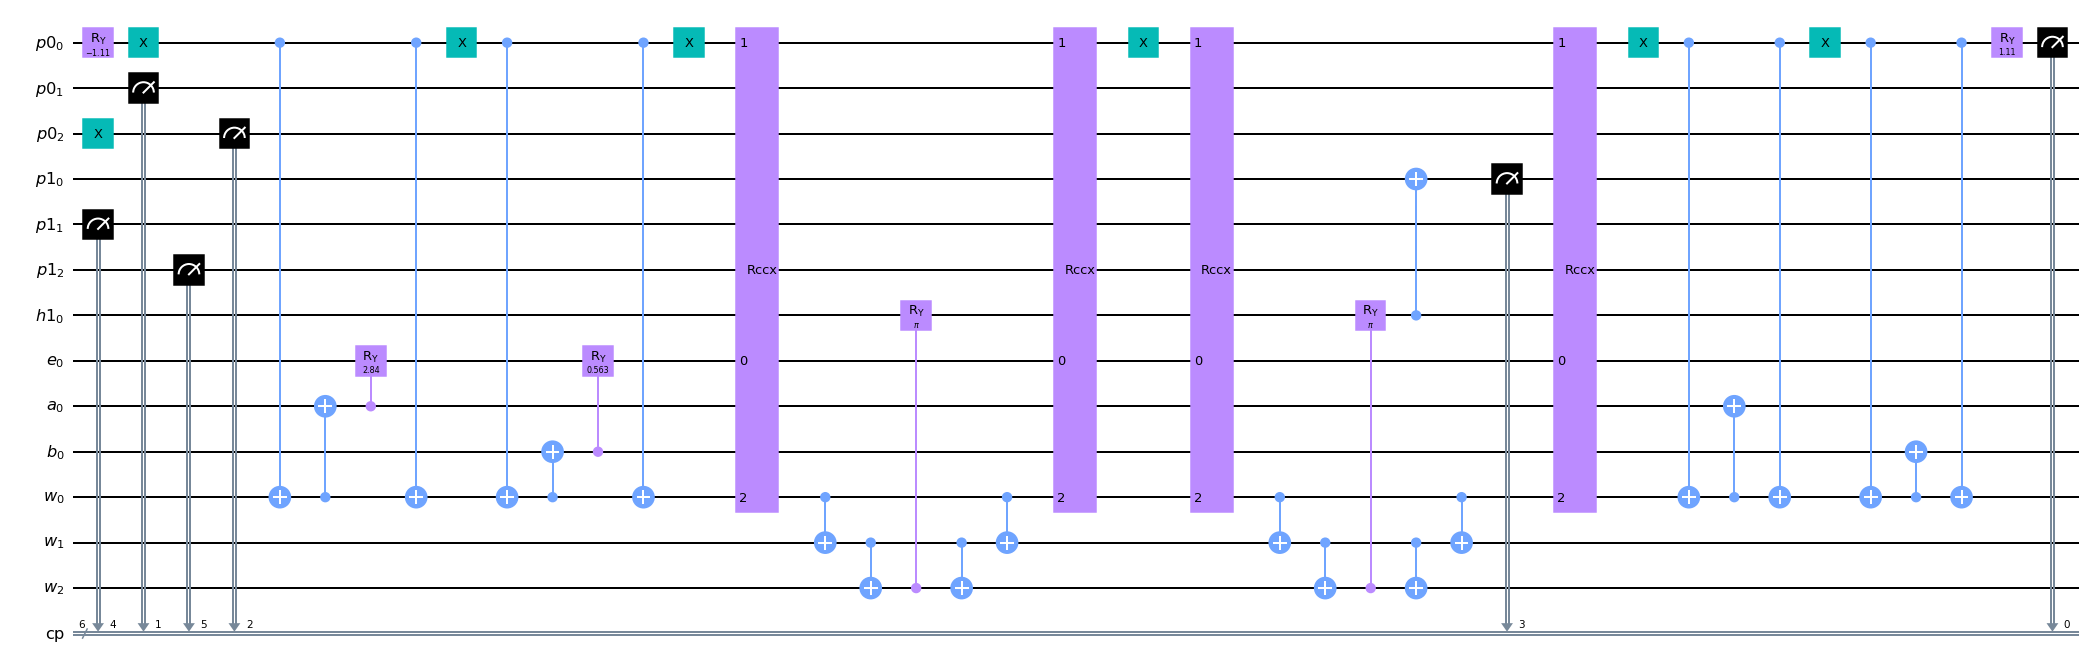

In [7]:
results_5[0].draw('mpl',fold=100)

In [8]:
run(step=1, backend=backend, threshold='0.05', qc_qcs=results_5, shots=10000)

Job id : 211ddacce73a4f49ae4fcc0b07e8a942-16486312890482419
Job Status: job has successfully run


In [9]:
results_20 = icepp.pass_manager(qc=circuit_LBNL1, level=2, backend=backend, backend_tket=dev_b, shots=8192, measure_type='qc', threshold_type=['constant',0.2], zne='off').auto_manager()

             ░    
 p0_0: ──────░────
       ┌───┐ ░    
 p0_1: ┤ X ├─░────
       ├───┤ ░ ┌─┐
 p0_2: ┤ X ├─░─┤M├
       └───┘ ░ └╥┘
 p1_0: ──────░──╫─
             ░  ║ 
 p1_1: ──────░──╫─
             ░  ║ 
 p1_2: ──────░──╫─
             ░  ║ 
 h1_0: ──────░──╫─
             ░  ║ 
  e_0: ──────░──╫─
             ░  ║ 
phi_0: ──────░──╫─
             ░  ║ 
  a_0: ──────░──╫─
             ░  ║ 
  b_0: ──────░──╫─
             ░  ║ 
  w_0: ──────░──╫─
             ░  ║ 
  w_1: ──────░──╫─
             ░  ║ 
  w_2: ──────░──╫─
             ░  ║ 
  c: 1/═════════╩═
                0 
Job id : 5637e6e1e1b54d46a3ddd55de94ebf39-1648631434087517
Job Status: job has successfully run
Raw counts: {'0': 48, '1': 8144}
Measurement error mitigated counts {'1': 8192.0}
Final counts after applying the threshold : {'1': 8192.0}
Threshold : 1638.4
       ┌─────────────┐┌───┐ ░ ┌─┐   
 p0_0: ┤ Ry(-1.1071) ├┤ X ├─░─┤M├───
       └────┬───┬────┘└───┘ ░ └╥┘┌─┐
 p0_1: ─────┤ X ├───────────░──╫─┤M├
        

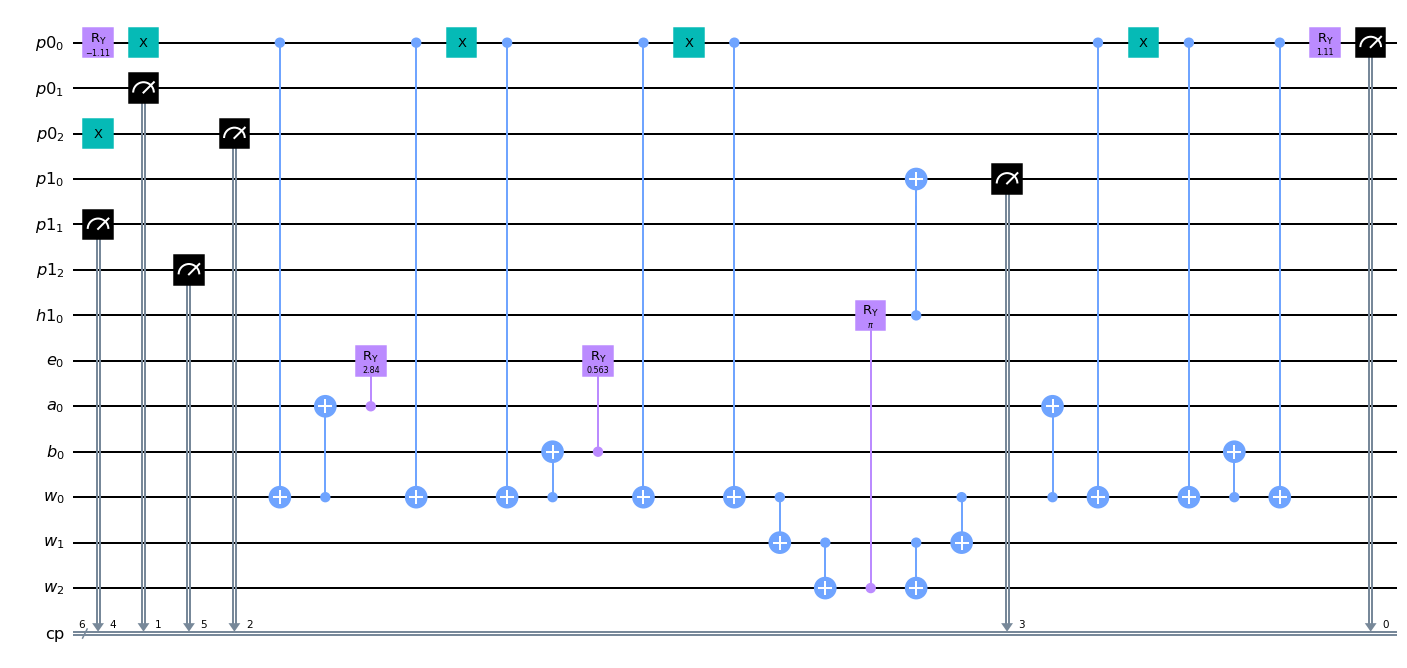

In [10]:
results_20[0].draw('mpl',fold=100)

In [11]:
run(step=1, backend=backend, threshold='0.2', qc_qcs=results_20, shots=10000)

Job id : 5ded114d09864753b36096ff80452d9b-1648632799544443
Job Status: job has successfully run


In [12]:
results_dynamic = icepp.pass_manager(qc=circuit_LBNL1, level=2, backend=backend, backend_tket=dev_b, shots=8192, measure_type='qc', threshold_type=['dynamic',None], zne='off').auto_manager()

             ░    
 p0_0: ──────░────
       ┌───┐ ░    
 p0_1: ┤ X ├─░────
       ├───┤ ░ ┌─┐
 p0_2: ┤ X ├─░─┤M├
       └───┘ ░ └╥┘
 p1_0: ──────░──╫─
             ░  ║ 
 p1_1: ──────░──╫─
             ░  ║ 
 p1_2: ──────░──╫─
             ░  ║ 
 h1_0: ──────░──╫─
             ░  ║ 
  e_0: ──────░──╫─
             ░  ║ 
phi_0: ──────░──╫─
             ░  ║ 
  a_0: ──────░──╫─
             ░  ║ 
  b_0: ──────░──╫─
             ░  ║ 
  w_0: ──────░──╫─
             ░  ║ 
  w_1: ──────░──╫─
             ░  ║ 
  w_2: ──────░──╫─
             ░  ║ 
  c: 1/═════════╩═
                0 
Job id : c7155a469e5446e6bfb6d85c6ae7a4f7-164863292862002
Job Status: job has successfully run
Raw counts: {'0': 41, '1': 8151}
Measurement error mitigated counts {'1': 8192.0}
Final counts after applying the threshold : {'1': 8192.0}
Threshold : 40.96
       ┌─────────────┐┌───┐ ░ ┌─┐   
 p0_0: ┤ Ry(-1.1071) ├┤ X ├─░─┤M├───
       └────┬───┬────┘└───┘ ░ └╥┘┌─┐
 p0_1: ─────┤ X ├───────────░──╫─┤M├
          

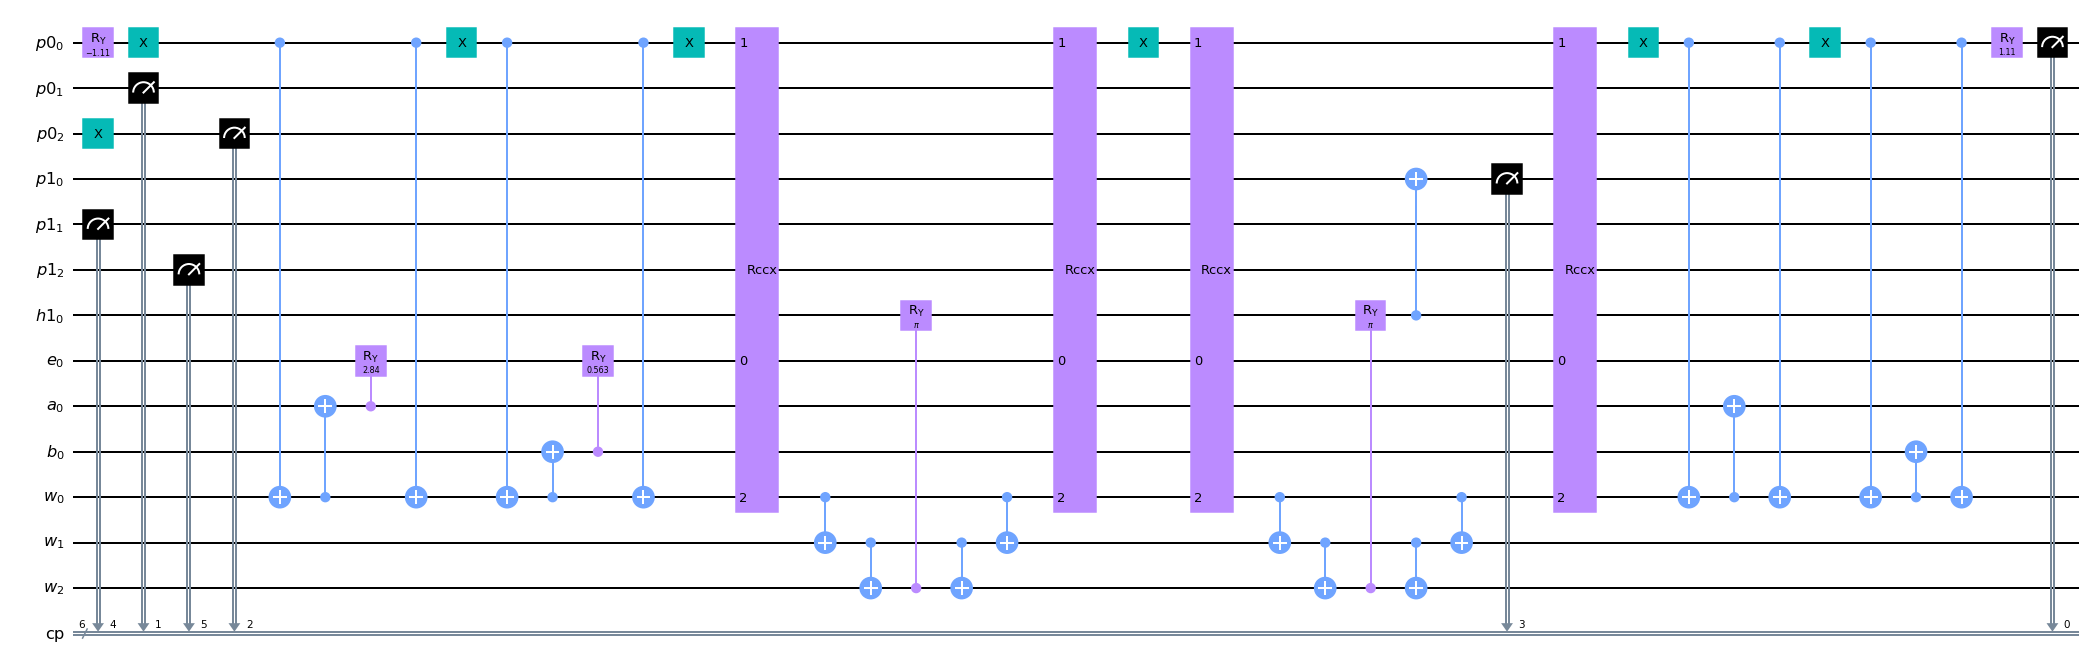

In [13]:
results_dynamic[0].draw(output='mpl',fold=100)

In [14]:
run(step=1, backend=backend, threshold='dynamic', qc_qcs=results_dynamic, shots=10000)

Job id : a3bef24e04d44af780e2852660ca7608-16486342513162858
Job Status: job has successfully run
